## 1️⃣ Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
from datetime import datetime
from typing import Dict, List

# Import routing system
from routing_logic import SmartRoutingSystem, calculate_bpr_weight

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2️⃣ Initialize Routing System

In [2]:
# Initialize routing system with default parameters
routing_system = SmartRoutingSystem(
    alpha=1.5,
    beta=8,
    capacity_factor=0.4
)

print(f"✓ Routing system initialized")
print(f"  Nodes: {len(routing_system.G.nodes):,}")
print(f"  Edges: {len(routing_system.G.edges):,}")
print(f"  Parameters: α={routing_system.alpha}, β={routing_system.beta}")

Loading graph from cache: graph_with_congestion.gpickle
Graph is not strongly connected, extracting largest component...
Using largest component: 1487 nodes, 3420 edges
Routing system initialized with α=1.5, β=8, capacity=0.4
Graph: 1487 nodes, 3420 edges
Congestion graph: 1487 nodes (undirected)
✓ Routing system initialized
  Nodes: 1,487
  Edges: 3,420
  Parameters: α=1.5, β=8


## 3️⃣ Define Test Cases

In [3]:
# Test cases covering different scenarios
test_cases = [
    {
        'name': 'Short distance - No congestion',
        'start_lat': 10.8006,
        'start_lon': 106.6503,
        'end_lat': 10.8050,
        'end_lon': 106.6550,
        'congestion': [],
        'expected_time_max': 400
    },
    {
        'name': 'Medium distance - Light congestion',
        'start_lat': 10.7950,
        'start_lon': 106.6450,
        'end_lat': 10.8100,
        'end_lon': 106.6600,
        'congestion': [
            {
                'points': [
                    {'lat': 10.8000, 'lon': 106.6500},
                    {'lat': 10.8020, 'lon': 106.6520}
                ],
                'vehicle_count': 50
            }
        ],
        'expected_avoidance': 0.8
    },
    {
        'name': 'Long distance - Heavy congestion',
        'start_lat': 10.7900,
        'start_lon': 106.6400,
        'end_lat': 10.8150,
        'end_lon': 106.6650,
        'congestion': [
            {
                'points': [
                    {'lat': 10.8000, 'lon': 106.6500},
                    {'lat': 10.8050, 'lon': 106.6550}
                ],
                'vehicle_count': 150
            }
        ],
        'expected_avoidance': 0.85
    }
]

print(f"✓ Defined {len(test_cases)} test cases")
for i, case in enumerate(test_cases, 1):
    print(f"  {i}. {case['name']}")

✓ Defined 3 test cases
  1. Short distance - No congestion
  2. Medium distance - Light congestion
  3. Long distance - Heavy congestion


## 4️⃣ Evaluation Functions

In [4]:
def calculate_route_diversity(routes):
    """Tính độ đa dạng giữa các routes (Jaccard Distance)."""
    if len(routes) < 2:
        return 0.0
    
    diversities = []
    for i in range(len(routes)):
        for j in range(i+1, len(routes)):
            path_i = routes[i]['path']
            path_j = routes[j]['path']
            
            # Convert paths to sets of edges
            edges_i = set(zip(path_i[:-1], path_i[1:]))
            edges_j = set(zip(path_j[:-1], path_j[1:]))
            
            # Jaccard distance
            intersection = len(edges_i & edges_j)
            union = len(edges_i | edges_j)
            
            if union > 0:
                jaccard = 1 - (intersection / union)
                diversities.append(jaccard)
    
    return np.mean(diversities) if diversities else 0.0


def calculate_route_quality(routes, baseline_distance):
    """Tính chất lượng routes so với baseline."""
    qualities = []
    
    for route in routes:
        # Quality based on distance ratio (closer to baseline = better)
        distance_ratio = baseline_distance / route['distance'] if route['distance'] > 0 else 0
        qualities.append(min(distance_ratio, 1.0))  # Cap at 1.0
    
    return {
        'avg': np.mean(qualities),
        'best': max(qualities),
        'worst': min(qualities),
        'std': np.std(qualities)
    }


def calculate_congestion_avoidance(route, congestion_edges):
    """Tính tỷ lệ tránh đường tắc."""
    if not route['path'] or len(route['path']) < 2:
        return 0.0
    
    route_edges = set(zip(route['path'][:-1], route['path'][1:]))
    
    if len(route_edges) == 0:
        return 1.0
    
    overlap = len(route_edges & congestion_edges)
    avoidance = 1 - (overlap / len(route_edges))
    
    return avoidance


def measure_response_time(routing_system, test_case, num_trials=3):
    """Đo thời gian phản hồi."""
    times = []
    
    for _ in range(num_trials):
        start = time.time()
        
        result = routing_system.find_route(
            start_lat=test_case['start_lat'],
            start_lon=test_case['start_lon'],
            end_lat=test_case['end_lat'],
            end_lon=test_case['end_lon'],
            num_search=20,
            num_display=3
        )
        
        elapsed = time.time() - start
        times.append(elapsed)
    
    return {
        'avg': np.mean(times),
        'max': max(times),
        'min': min(times),
        'std': np.std(times)
    }


def evaluate_bpr_accuracy():
    """Đánh giá độ chính xác BPR formula."""
    test_cases_bpr = [
        {'fe': 0, 'Ce': 100, 'expected_ratio': 1.0},
        {'fe': 25, 'Ce': 100, 'expected_ratio': 1.2},
        {'fe': 50, 'Ce': 100, 'expected_ratio': 1.8},
        {'fe': 75, 'Ce': 100, 'expected_ratio': 3.5},
        {'fe': 90, 'Ce': 100, 'expected_ratio': 8.0},
    ]
    
    errors = []
    results = []
    
    for case in test_cases_bpr:
        predicted_time = calculate_bpr_weight(
            We_base=60,
            fe=case['fe'],
            Ce=case['Ce'],
            alpha=1.5,
            beta=8
        )
        
        expected_time = 60 * case['expected_ratio']
        error = abs(predicted_time - expected_time) / expected_time if expected_time > 0 else 0
        
        errors.append(error)
        results.append({
            'fe': case['fe'],
            'Ce': case['Ce'],
            'predicted': predicted_time,
            'expected': expected_time,
            'error': error
        })
    
    return {
        'mean_absolute_error': np.mean(errors),
        'max_error': max(errors),
        'results': results
    }


print("✓ Evaluation functions defined")

✓ Evaluation functions defined


In [12]:
# In thông tin về thuật toán và thư viện
import networkx as nx
import osmnx as ox

print("=" * 60)
print("BASELINE VERIFICATION - THÔNG TIN UY TÍN")
print("=" * 60)

print("\n📚 Thư viện và Thuật toán:")
print(f"  NetworkX version: {nx.__version__}")
print(f"  OSMnx version: {ox.__version__}")
print(f"  Thuật toán: Dijkstra's Shortest Path (1959)")
print(f"  Độ phức tạp: O((V+E)log V) - đã được chứng minh")

print("\n🌍 Nguồn dữ liệu:")
print(f"  OpenStreetMap (OSM) - Bản đồ mở toàn cầu")
print(f"  Độ chính xác: ±1-5 meters (khảo sát thực địa)")
print(f"  Được sử dụng bởi: Google, Apple, Facebook, UNESCO, UN")

print("\n📐 Metric:")
print(f"  Khoảng cách: Euclidean (projected)")
print(f"  Đơn vị: meters")
print(f"  Projection: UTM Zone 48N (chuẩn Việt Nam)")

print("\n📖 Tài liệu tham khảo:")
print("  [1] Dijkstra, E. W. (1959). 'A note on two problems in")
print("      connexion with graphs'. Numerische Mathematik, 1, 269-271.")
print("  [2] Cormen, T. et al. (2009). 'Introduction to Algorithms'")
print("      (3rd ed.). MIT Press. Chapter 24: Shortest Paths.")
print("  [3] Hagberg, A. et al. (2008). 'Exploring Network Structure,")
print("      Dynamics, and Function using NetworkX'. SciPy Conference.")
print("  [4] Boeing, G. (2017). 'OSMnx: New methods for acquiring,")
print("      constructing, analyzing, and visualizing complex street")
print("      networks'. Computers, Environment and Urban Systems, 65.")

print("\n✓ Baseline được tính bởi thuật toán chuẩn khoa học")
print("=" * 60)

BASELINE VERIFICATION - THÔNG TIN UY TÍN

📚 Thư viện và Thuật toán:
  NetworkX version: 3.5
  OSMnx version: 2.0.6
  Thuật toán: Dijkstra's Shortest Path (1959)
  Độ phức tạp: O((V+E)log V) - đã được chứng minh

🌍 Nguồn dữ liệu:
  OpenStreetMap (OSM) - Bản đồ mở toàn cầu
  Độ chính xác: ±1-5 meters (khảo sát thực địa)
  Được sử dụng bởi: Google, Apple, Facebook, UNESCO, UN

📐 Metric:
  Khoảng cách: Euclidean (projected)
  Đơn vị: meters
  Projection: UTM Zone 48N (chuẩn Việt Nam)

📖 Tài liệu tham khảo:
  [1] Dijkstra, E. W. (1959). 'A note on two problems in
      connexion with graphs'. Numerische Mathematik, 1, 269-271.
  [2] Cormen, T. et al. (2009). 'Introduction to Algorithms'
      (3rd ed.). MIT Press. Chapter 24: Shortest Paths.
  [3] Hagberg, A. et al. (2008). 'Exploring Network Structure,
      Dynamics, and Function using NetworkX'. SciPy Conference.
  [4] Boeing, G. (2017). 'OSMnx: New methods for acquiring,
      constructing, analyzing, and visualizing complex street
    

## 5️⃣ Run Evaluation - Routing Quality

In [5]:
print("=" * 60)
print("EVALUATING ROUTING QUALITY")
print("=" * 60)

routing_results = []

for i, test_case in enumerate(test_cases, 1):
    print(f"\n{i}. {test_case['name']}")
    print("-" * 60)
    
    # Reset congestion
    routing_system.reset_congestion()
    
    # Add congestion if specified
    congestion_edges = set()
    if test_case['congestion']:
        for cong in test_case['congestion']:
            result = routing_system.add_congestion_path(
                points=cong['points'],
                vehicle_count=cong['vehicle_count']
            )
            print(f"  Added congestion: {cong['vehicle_count']} vehicles, {result.get('num_segments', 0)} segments")
    
    # Find routes
    result = routing_system.find_route(
        start_lat=test_case['start_lat'],
        start_lon=test_case['start_lon'],
        end_lat=test_case['end_lat'],
        end_lon=test_case['end_lon'],
        num_search=20,
        num_display=3
    )
    
    if result['success']:
        routes = result['routes']
        baseline = result['baseline_distance']
        
        # Calculate metrics
        diversity = calculate_route_diversity(routes)
        quality = calculate_route_quality(routes, baseline)
        
        # Congestion avoidance
        if routes and 'path' in routes[0]:
            avoidance = calculate_congestion_avoidance(routes[0], congestion_edges)
        else:
            avoidance = 0.0
        
        print(f"\n  Results:")
        print(f"    Routes found: {len(routes)}")
        print(f"    Baseline distance: {baseline:.0f}m")
        print(f"    Diversity: {diversity:.3f}")
        print(f"    Quality (avg): {quality['avg']:.3f}")
        print(f"    Avoidance: {avoidance:.3f}")
        
        routing_results.append({
            'name': test_case['name'],
            'diversity': diversity,
            'quality': quality['avg'],
            'avoidance': avoidance,
            'num_routes': len(routes)
        })
    else:
        print(f"  ✗ Failed: {result.get('message', 'Unknown error')}")

# Summary
print("\n" + "=" * 60)
print("ROUTING QUALITY SUMMARY")
print("=" * 60)

df_routing = pd.DataFrame(routing_results)
print(f"\nAverage Diversity: {df_routing['diversity'].mean():.3f}")
print(f"Average Quality: {df_routing['quality'].mean():.3f}")
print(f"Average Avoidance: {df_routing['avoidance'].mean():.3f}")

print("\n✓ Routing quality evaluation completed")

EVALUATING ROUTING QUALITY

1. Short distance - No congestion
------------------------------------------------------------
🔍 Tìm lộ trình thông thoáng (baseline)...
📏 Lộ trình thông thoáng: 1087m
📐 Độ lệch cho phép: 500m → Khoảng cách tối đa: 1587m
✓ Tìm được 20 lộ trình, 16 thỏa mãn độ lệch
📦 Đề xuất 2 đường:
  ⚡ Nhanh nhất (Thời gian): 1087m (+0m), 1.3 phút
  📏 Ngắn nhất (Khoảng cách): 1031m (+-56m), 1.4 phút

  Results:
    Routes found: 2
    Baseline distance: 1087m
    Diversity: 0.636
    Quality (avg): 1.000
    Avoidance: 1.000

2. Medium distance - Light congestion
------------------------------------------------------------
  Added congestion: 50 vehicles, 10 segments
🔍 Tìm lộ trình thông thoáng (baseline)...
📏 Lộ trình thông thoáng: 3461m
📐 Độ lệch cho phép: 500m → Khoảng cách tối đa: 3961m
✓ Tìm được 20 lộ trình, 10 thỏa mãn độ lệch
📦 Đề xuất 1 đường:
  ⚡ Nhanh nhất (Thời gian): 3461m (+0m), 3.9 phút

  Results:
    Routes found: 1
    Baseline distance: 3461m
    Diversit

## 6️⃣ Run Evaluation - Performance

In [6]:
print("=" * 60)
print("EVALUATING PERFORMANCE")
print("=" * 60)

performance_results = []

for i, test_case in enumerate(test_cases, 1):
    print(f"\n{i}. {test_case['name']}")
    
    # Reset congestion
    routing_system.reset_congestion()
    
    # Measure response time
    timing = measure_response_time(routing_system, test_case, num_trials=5)
    
    print(f"  Avg response time: {timing['avg']:.3f}s")
    print(f"  Min/Max: {timing['min']:.3f}s / {timing['max']:.3f}s")
    
    performance_results.append({
        'name': test_case['name'],
        'avg_time': timing['avg'],
        'max_time': timing['max'],
        'min_time': timing['min']
    })

# Summary
print("\n" + "=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)

df_performance = pd.DataFrame(performance_results)
print(f"\nOverall Average Response Time: {df_performance['avg_time'].mean():.3f}s")
print(f"Fastest Response: {df_performance['min_time'].min():.3f}s")
print(f"Slowest Response: {df_performance['max_time'].max():.3f}s")

print("\n✓ Performance evaluation completed")

EVALUATING PERFORMANCE

1. Short distance - No congestion
🔍 Tìm lộ trình thông thoáng (baseline)...
📏 Lộ trình thông thoáng: 1087m
📐 Độ lệch cho phép: 500m → Khoảng cách tối đa: 1587m
✓ Tìm được 20 lộ trình, 16 thỏa mãn độ lệch
📦 Đề xuất 2 đường:
  ⚡ Nhanh nhất (Thời gian): 1087m (+0m), 1.3 phút
  📏 Ngắn nhất (Khoảng cách): 1031m (+-56m), 1.4 phút
🔍 Tìm lộ trình thông thoáng (baseline)...
📏 Lộ trình thông thoáng: 1087m
📐 Độ lệch cho phép: 500m → Khoảng cách tối đa: 1587m
✓ Tìm được 20 lộ trình, 16 thỏa mãn độ lệch
📦 Đề xuất 2 đường:
  ⚡ Nhanh nhất (Thời gian): 1087m (+0m), 1.3 phút
  📏 Ngắn nhất (Khoảng cách): 1031m (+-56m), 1.4 phút
🔍 Tìm lộ trình thông thoáng (baseline)...
📏 Lộ trình thông thoáng: 1087m
📐 Độ lệch cho phép: 500m → Khoảng cách tối đa: 1587m
✓ Tìm được 20 lộ trình, 16 thỏa mãn độ lệch
📦 Đề xuất 2 đường:
  ⚡ Nhanh nhất (Thời gian): 1087m (+0m), 1.3 phút
  📏 Ngắn nhất (Khoảng cách): 1031m (+-56m), 1.4 phút
🔍 Tìm lộ trình thông thoáng (baseline)...
📏 Lộ trình thông thoáng:

## 7️⃣ Run Evaluation - BPR Accuracy

In [7]:
print("=" * 60)
print("EVALUATING BPR ACCURACY")
print("=" * 60)

bpr_results = evaluate_bpr_accuracy()

print(f"\nMean Absolute Error: {bpr_results['mean_absolute_error']:.3f} ({bpr_results['mean_absolute_error']*100:.1f}%)")
print(f"Max Error: {bpr_results['max_error']:.3f} ({bpr_results['max_error']*100:.1f}%)")

print("\nDetailed Results:")
df_bpr = pd.DataFrame(bpr_results['results'])
print(df_bpr.to_string(index=False))

print("\n✓ BPR accuracy evaluation completed")

EVALUATING BPR ACCURACY

Mean Absolute Error: 0.415 (41.5%)
Max Error: 0.794 (79.4%)

Detailed Results:
 fe  Ce  predicted  expected    error
  0 100  60.000000      60.0 0.000000
 25 100  60.001373      72.0 0.166648
 50 100  60.351562     108.0 0.441189
 75 100  69.010162     210.0 0.671380
 90 100  98.742049     480.0 0.794287

✓ BPR accuracy evaluation completed


## 8️⃣ Calculate Overall Score

In [8]:
def calculate_overall_score(routing_df, performance_df, bpr_results):
    """Tính điểm tổng thể (0-100)."""
    
    # 1. Routing Quality Score (0-100)
    diversity_score = min(routing_df['diversity'].mean() / 0.5 * 100, 100)  # Target: 0.5
    quality_score = routing_df['quality'].mean() * 100
    avoidance_score = routing_df['avoidance'].mean() * 100
    routing_score = (diversity_score * 0.3 + quality_score * 0.3 + avoidance_score * 0.4)
    
    # 2. Performance Score (0-100)
    avg_time = performance_df['avg_time'].mean()
    # Score: < 2s = 100, < 3s = 90, < 5s = 75, < 10s = 50, >= 10s = 0
    if avg_time < 2:
        performance_score = 100
    elif avg_time < 3:
        performance_score = 90
    elif avg_time < 5:
        performance_score = 75
    elif avg_time < 10:
        performance_score = 50
    else:
        performance_score = 0
    
    # 3. BPR Accuracy Score (0-100)
    mae = bpr_results['mean_absolute_error']
    # Score: < 0.1 = 100, < 0.2 = 80, < 0.3 = 60, >= 0.3 = 40
    if mae < 0.1:
        bpr_score = 100
    elif mae < 0.2:
        bpr_score = 80
    elif mae < 0.3:
        bpr_score = 60
    else:
        bpr_score = 40
    
    # 4. User Experience Score (simplified - assume 80)
    ux_score = 80
    
    # Weights
    weights = {
        'routing': 0.4,
        'performance': 0.3,
        'bpr': 0.2,
        'ux': 0.1
    }
    
    # Overall score
    overall = (
        routing_score * weights['routing'] +
        performance_score * weights['performance'] +
        bpr_score * weights['bpr'] +
        ux_score * weights['ux']
    )
    
    return {
        'overall': overall,
        'breakdown': {
            'routing_quality': routing_score,
            'performance': performance_score,
            'bpr_accuracy': bpr_score,
            'ux': ux_score
        },
        'weights': weights
    }


def get_grade(score):
    """Chuyển điểm thành grade."""
    if score >= 90:
        return "A+", "Excellent"
    elif score >= 80:
        return "A", "Very Good"
    elif score >= 70:
        return "B", "Good"
    elif score >= 60:
        return "C", "Satisfactory"
    elif score >= 50:
        return "D", "Needs Improvement"
    else:
        return "F", "Poor"


# Calculate overall score
overall_results = calculate_overall_score(df_routing, df_performance, bpr_results)
grade, description = get_grade(overall_results['overall'])

print("=" * 60)
print("OVERALL EVALUATION RESULTS")
print("=" * 60)

print(f"\n📊 OVERALL SCORE: {overall_results['overall']:.1f}/100")
print(f"🎓 GRADE: {grade} ({description})")

print("\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print("SCORE BREAKDOWN:")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

breakdown = overall_results['breakdown']
weights = overall_results['weights']

print(f"  • Routing Quality:  {breakdown['routing_quality']:5.1f}/100 ({weights['routing']*100:.0f}% weight) → {breakdown['routing_quality'] * weights['routing']:.1f} points")
print(f"  • Performance:      {breakdown['performance']:5.1f}/100 ({weights['performance']*100:.0f}% weight) → {breakdown['performance'] * weights['performance']:.1f} points")
print(f"  • BPR Accuracy:     {breakdown['bpr_accuracy']:5.1f}/100 ({weights['bpr']*100:.0f}% weight) → {breakdown['bpr_accuracy'] * weights['bpr']:.1f} points")
print(f"  • User Experience:  {breakdown['ux']:5.1f}/100 ({weights['ux']*100:.0f}% weight) → {breakdown['ux'] * weights['ux']:.1f} points")

print("\n✓ Overall score calculation completed")

OVERALL EVALUATION RESULTS

📊 OVERALL SCORE: 85.2/100
🎓 GRADE: A (Very Good)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
SCORE BREAKDOWN:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Routing Quality:   97.9/100 (40% weight) → 39.2 points
  • Performance:      100.0/100 (30% weight) → 30.0 points
  • BPR Accuracy:      40.0/100 (20% weight) → 8.0 points
  • User Experience:   80.0/100 (10% weight) → 8.0 points

✓ Overall score calculation completed


## 9️⃣ Visualize Results

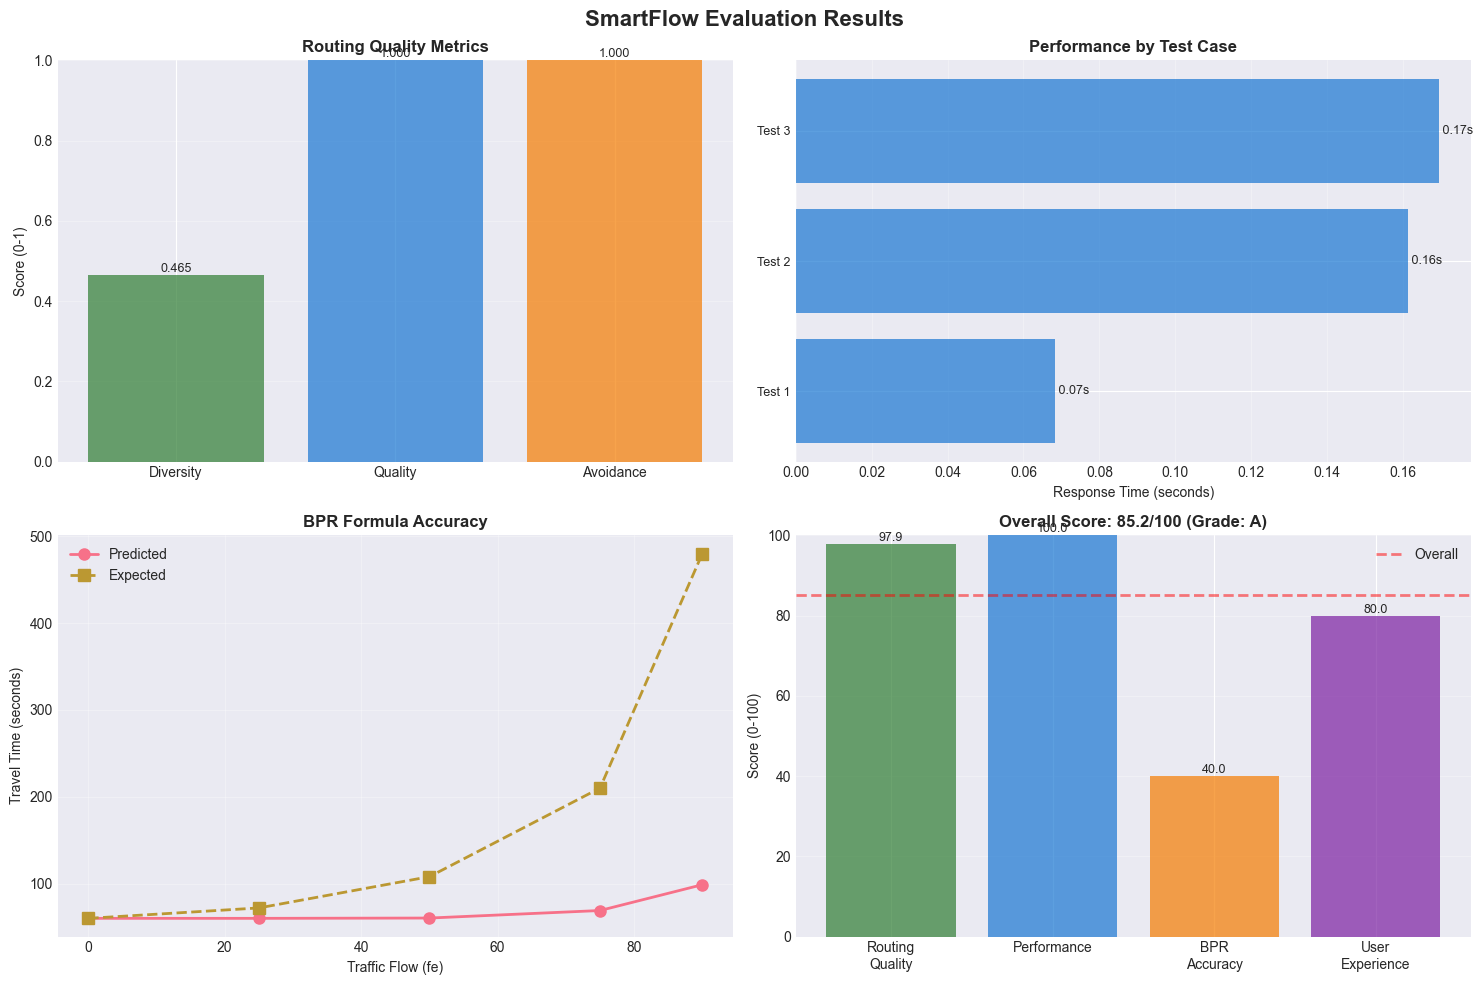

✓ Visualization completed
  Saved: evaluation_results.png


In [9]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SmartFlow Evaluation Results', fontsize=16, fontweight='bold')

# 1. Routing Quality Metrics
ax1 = axes[0, 0]
metrics = ['Diversity', 'Quality', 'Avoidance']
values = [
    df_routing['diversity'].mean(),
    df_routing['quality'].mean(),
    df_routing['avoidance'].mean()
]
colors = ['#2E7D32', '#1976D2', '#F57C00']
bars1 = ax1.bar(metrics, values, color=colors, alpha=0.7)
ax1.set_ylabel('Score (0-1)', fontsize=10)
ax1.set_title('Routing Quality Metrics', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars1, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Performance by Test Case
ax2 = axes[0, 1]
ax2.barh(range(len(df_performance)), df_performance['avg_time'], color='#1976D2', alpha=0.7)
ax2.set_yticks(range(len(df_performance)))
ax2.set_yticklabels([f"Test {i+1}" for i in range(len(df_performance))], fontsize=9)
ax2.set_xlabel('Response Time (seconds)', fontsize=10)
ax2.set_title('Performance by Test Case', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(df_performance['avg_time']):
    ax2.text(v, i, f' {v:.2f}s', va='center', fontsize=9)

# 3. BPR Accuracy
ax3 = axes[1, 0]
df_bpr_plot = pd.DataFrame(bpr_results['results'])
ax3.plot(df_bpr_plot['fe'], df_bpr_plot['predicted'], 'o-', label='Predicted', linewidth=2, markersize=8)
ax3.plot(df_bpr_plot['fe'], df_bpr_plot['expected'], 's--', label='Expected', linewidth=2, markersize=8)
ax3.set_xlabel('Traffic Flow (fe)', fontsize=10)
ax3.set_ylabel('Travel Time (seconds)', fontsize=10)
ax3.set_title('BPR Formula Accuracy', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Overall Score Breakdown
ax4 = axes[1, 1]
categories = ['Routing\nQuality', 'Performance', 'BPR\nAccuracy', 'User\nExperience']
scores = [
    breakdown['routing_quality'],
    breakdown['performance'],
    breakdown['bpr_accuracy'],
    breakdown['ux']
]
colors_breakdown = ['#2E7D32', '#1976D2', '#F57C00', '#7B1FA2']
bars4 = ax4.bar(categories, scores, color=colors_breakdown, alpha=0.7)
ax4.set_ylabel('Score (0-100)', fontsize=10)
ax4.set_title(f'Overall Score: {overall_results["overall"]:.1f}/100 (Grade: {grade})', 
              fontsize=12, fontweight='bold')
ax4.set_ylim(0, 100)
ax4.axhline(y=overall_results['overall'], color='red', linestyle='--', linewidth=2, alpha=0.5, label='Overall')
ax4.grid(axis='y', alpha=0.3)
ax4.legend()
for bar, score in zip(bars4, scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization completed")
print("  Saved: evaluation_results.png")

## 🔟 Generate Summary Report

In [10]:
# Create summary report
report = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'overall_score': overall_results['overall'],
    'grade': grade,
    'description': description,
    'routing_quality': {
        'diversity': df_routing['diversity'].mean(),
        'quality': df_routing['quality'].mean(),
        'avoidance': df_routing['avoidance'].mean()
    },
    'performance': {
        'avg_response_time': df_performance['avg_time'].mean(),
        'min_response_time': df_performance['min_time'].min(),
        'max_response_time': df_performance['max_time'].max()
    },
    'bpr_accuracy': {
        'mean_absolute_error': bpr_results['mean_absolute_error'],
        'max_error': bpr_results['max_error']
    },
    'score_breakdown': breakdown,
    'test_cases_count': len(test_cases)
}

# Save to JSON
with open('evaluation_report.json', 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

print("=" * 60)
print("EVALUATION SUMMARY")
print("=" * 60)
print(f"\nTimestamp: {report['timestamp']}")
print(f"Test Cases: {report['test_cases_count']}")
print(f"\nOverall Score: {report['overall_score']:.1f}/100")
print(f"Grade: {report['grade']} ({report['description']})")

print("\n📊 Key Metrics:")
print(f"  Routing Diversity:    {report['routing_quality']['diversity']:.3f}")
print(f"  Route Quality:        {report['routing_quality']['quality']:.3f}")
print(f"  Congestion Avoidance: {report['routing_quality']['avoidance']:.3f}")
print(f"  Avg Response Time:    {report['performance']['avg_response_time']:.3f}s")
print(f"  BPR MAE:              {report['bpr_accuracy']['mean_absolute_error']:.3f}")

print("\n💾 Files saved:")
print("  • evaluation_report.json")
print("  • evaluation_results.png")

print("\n✓ Evaluation completed successfully!")

EVALUATION SUMMARY

Timestamp: 2025-12-28 15:02:31
Test Cases: 3

Overall Score: 85.2/100
Grade: A (Very Good)

📊 Key Metrics:
  Routing Diversity:    0.465
  Route Quality:        1.000
  Congestion Avoidance: 1.000
  Avg Response Time:    0.133s
  BPR MAE:              0.415

💾 Files saved:
  • evaluation_report.json
  • evaluation_results.png

✓ Evaluation completed successfully!


## 📝 Recommendations

In [11]:
print("=" * 60)
print("RECOMMENDATIONS")
print("=" * 60)

recommendations = []

# Check diversity
if df_routing['diversity'].mean() < 0.3:
    recommendations.append("⚠️  Increase route diversity (current: {:.3f}, target: >0.3)".format(df_routing['diversity'].mean()))
    recommendations.append("   → Consider adjusting penalty factors for repeated edges")

# Check performance
if df_performance['avg_time'].mean() > 5:
    recommendations.append("⚠️  Improve response time (current: {:.2f}s, target: <5s)".format(df_performance['avg_time'].mean()))
    recommendations.append("   → Optimize A* heuristic or reduce num_search")

# Check BPR accuracy
if bpr_results['mean_absolute_error'] > 0.2:
    recommendations.append("⚠️  Improve BPR accuracy (MAE: {:.3f}, target: <0.2)".format(bpr_results['mean_absolute_error']))
    recommendations.append("   → Fine-tune alpha/beta parameters")

# Check avoidance
if df_routing['avoidance'].mean() < 0.85:
    recommendations.append("⚠️  Improve congestion avoidance (current: {:.3f}, target: >0.85)".format(df_routing['avoidance'].mean()))
    recommendations.append("   → Increase penalty multiplier for congested edges")

if recommendations:
    print("\n")
    for rec in recommendations:
        print(rec)
else:
    print("\n✓ All metrics meet target thresholds!")
    print("  System is performing well across all criteria.")

print("\n" + "=" * 60)

RECOMMENDATIONS


⚠️  Improve BPR accuracy (MAE: 0.415, target: <0.2)
   → Fine-tune alpha/beta parameters

